<a href="https://colab.research.google.com/github/TonioFlag/ProyectoFinalColas/blob/main/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pingouin
!pip install distfit

In [326]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import pingouin as pg
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from distfit import distfit
import matplotlib.pyplot as plt

In [3]:
arribo=pd.read_excel('/content/drive/MyDrive/Actual/COLAS/Tasas de arribo.xlsx')

num=[]
for i in arribo['dia']:
  if i=="Lunes":
    num.append(1)
  elif i=="Martes":
    num.append(2)
  elif i=="Miercoles":
    num.append(3)
  elif i=="Jueves":
    num.append(4)
  elif i=="Sabado":
    num.append(6)
  elif i=="Viernes":
    num.append(5)
  elif i=="Domingo":
    num.append(7)

arribo['num_dia']=num

intervalos=5
amplitud=arribo.min_cliente.max()-arribo.min_cliente.min()
intervalo=amplitud/5
clasificacion=[]
for i in arribo.min_cliente:
  if i <= intervalo: clasificacion.append(1)
  elif i <= 2*intervalo: clasificacion.append(2)
  elif i <= 3*intervalo: clasificacion.append(3)
  elif i <= 4*intervalo: clasificacion.append(4)
  elif i <= 5*intervalo: clasificacion.append(5)

arribo['clase']=clasificacion


arribo['Llegada']=pd.to_datetime(arribo['Llegada'],format='%H:%M:%S')

intervalos = [(6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22)]
es=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

def asignar_intervalo(hora):
    for i in range(len(intervalos)):
        if intervalos[i][0] <= hora.hour < intervalos[i][1]:
            return es[i]

arribo['intervalo'] = arribo['Llegada'].apply(asignar_intervalo)

meses_dict = {'Abril': 4, 'Septiembre': 9,'Noviembre': 11}
arribo['num_mes'] = arribo['Mes'].map(meses_dict)
servicios=list(arribo['TipoServ.'].unique())
servicio = {servicios[0]: 1, servicios[1]: 2,servicios[2]: 3,servicios[3]: 4,servicios[4]: 5}
arribo['tipo_serv'] = arribo['TipoServ.'].map(servicio)


#Funciones para automatizar gráficas, fit y otros.


##Para gráficos de disperción que utilizan kmeans, pidiendo el turno y el numero de clusteres.

In [322]:
def dispercion(tur,n_kluster):
  base=arribo[(arribo['Turno']==tur)]
  base=base.reset_index()
  X = np.array(base['min_cliente']).reshape(-1, 1)
  kmeans = KMeans(n_clusters=n_kluster, random_state=42)
  kmeans.fit(X)
  base['kmeans'] = kmeans.labels_

  plt.figure(figsize=(8, 6))

    # Iterar sobre los clústeres y visualizar la dispersión
  for evaluando in base['kmeans'].unique():
    cluster_data = base[base['kmeans'] == evaluando]
    x = len(cluster_data) - 1
    plt.scatter(cluster_data['min_cliente'][:x],
                cluster_data['min_cliente'][1:],
                label=f'Cluster {evaluando}',
                s=8,
                alpha=0.7)

    # Configurar etiquetas y leyenda
  plt.xlabel("Tiempo de llegada (Xi)")
  plt.ylabel("Tiempo de llegada siguiente (Xi+1)")
  plt.title(f"Scatter plot de tiempos de arribo - Turno {tur}")
  plt.legend(title="Cluster")

    # Mostrar el gráfico
  plt.show()

##Clusters en 1D con la libreria plt

In [331]:
def grafica1d(turno,clus):
  base=arribo[(arribo['Turno']==turno)]
  x=range(len(base['min_cliente'])-1)
  par=[]
  for i in x:
    mete=(base['min_cliente'].iloc[i],base['min_cliente'].iloc[i+1])
    par.append(mete)
  X=np.array(par).reshape(-1,1)

  reduced_data = PCA(n_components=1).fit_transform(X)
  kmeans = KMeans(init="k-means++", n_clusters=clus, n_init=4)
  kmeans.fit(reduced_data)

  reduced_data = PCA(n_components=1).fit_transform(X)

  # Aplicar K-means
  kmeans = KMeans(init="k-means++", n_clusters=clus, n_init=4)
  kmeans.fit(reduced_data)

  # Visualización
  # Visualización
  plt.figure(figsize=(8, 6))

  # Scatter plot de los datos originales
  plt.scatter(reduced_data, np.zeros_like(reduced_data), c=kmeans.labels_, cmap='viridis', s=50, edgecolors='k', alpha=0.6)

  # Scatter plot de los centroides
  centroids = kmeans.cluster_centers_
  plt.scatter(centroids, np.zeros_like(centroids), marker="x", s=200, linewidths=3, color="r", zorder=10)

  plt.title("K-means clustering on 1D data para el turno "+str(turno)+"\n las X marcan los clusters")
  plt.xlabel("Tiempo de llegada (Xi)")
  plt.show()

##Para sacar las pruebas fit



In [378]:
def fit(turno,ncluster,filtro):
  base=arribo[(arribo['Turno']==turno)]
  base=base.reset_index()
  X = np.array(base['min_cliente']).reshape(-1, 1)
  kmeans = KMeans(n_clusters=ncluster, random_state=42)
  kmeans.fit(X)
  base['kmeans'] = kmeans.labels_

  base=base[(base['intervalo']!=filtro)]
  base=base.reset_index()

  for i in base['kmeans'].unique():

    dfit = distfit()
    results2 = dfit.fit_transform(base[(base['kmeans']==i)]['min_cliente'])
    results2['summary'].to_excel("grupo_"+str(i)+".xlsx")

    dfit.plot()

##Sacando el procentaje de participación y los datos que representa

In [384]:
def exportarinfo(turno,ncluster,filtro):


  base=arribo[(arribo['Turno']==turno)]
  base=base.reset_index()
  X = np.array(base['min_cliente']).reshape(-1, 1)
  kmeans = KMeans(n_clusters=ncluster, random_state=42)
  kmeans.fit(X)
  base['kmeans'] = kmeans.labels_

  base=base[(base['intervalo']!=filtro)]
  base=base.reset_index()

  cosas=["Mes","dia","TipoServ.","Servidor","Cuadrilla","intervalo"]

  with pd.ExcelWriter("informacion.xlsx") as writer:
        for i in cosas:
            crosstab_result = pd.crosstab(base['kmeans'], base[i])
            normalized_result = pd.crosstab(base['kmeans'], base[i], normalize='index')
            export = pd.concat([crosstab_result, normalized_result], keys=['Count', 'Percentage'])
            export.to_excel(writer, sheet_name=i)

In [374]:
exportarinfo(1,5,1000)

In [385]:
exportarinfo(2,2,15)

In [382]:
base=arribo[(arribo['intervalo']==15)]
cosas=["Mes","dia","TipoServ.","Servidor","Cuadrilla","intervalo"]
with pd.ExcelWriter("informacion_intervalo_15.xlsx") as writer:
  for i in cosas:
    crosstab_result = pd.crosstab(base['intervalo'], base[i])
    normalized_result = pd.crosstab(base['intervalo'], base[i], normalize='index')
    export = pd.concat([crosstab_result, normalized_result], keys=['Count', 'Percentage'])
    export.to_excel(writer, sheet_name=i)

##Para hacer gráficas de cajas y bigotes


In [343]:
def box(turno,kmeans,columna,grupo):
  base['kmeans']=df[kmeans]
  m=list(base[columna].unique())
  g = [base[(base['kmeans']==grupo)&(base[columna] == m[i])]['min_cliente'] for i in range(len(m))]
  fig, ax = plt.subplots(1, 1)
  ax.boxplot(g)
  ax.set_xticklabels(m)
  ax.set_ylabel("var")
  return plt.show()

#Hallando los kmeans, para determinar agrupamientos.
 Se descubre que para el turno 1 se puede representar en 5 grupos y, el turno 2 solo tiene una agrupación (de 2) que casi cumple con todas las pruebas, por lo que se analiza particularmente mediante grafica de cajas y bigotes para verficar de otra forma su representación. Quedando que se debe apartar el intervalo 15 del conjunto, teniendo en cuenta que la hora maxima de arribo son las $20:33:16$ por lo que se concluye no representativo este intervalo, pasando a representarlo de forma individual o en defecto no siendo representado.



In [362]:
kruskal,levene,pruebavar=pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
arreglo=[]
sorce=[]
turno=[]

for t in [1,2]:
  base=arribo[(arribo['Turno']==t)]
  base=base.reset_index()
  X = np.array(base['min_cliente']).reshape(-1, 1)
  df=pd.DataFrame()

  for k in [2,3,4,5,6,7,8,9,10,11,12,13,14]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    df[k] = kmeans.labels_
  cosas=["Mes","dia","TipoServ.","intervalo","Cuadrilla"]

  for k in list(df.columns):
    base['kmeans']=df[k]

    for i in base['kmeans'].unique():
      eval=base[(base['kmeans']==i)]

      for j in cosas:
        if len(eval[j].unique())>1:
          mete=(k,i)
          sorce.append(j)
          turno.append(t)
          arreglo.append(mete)
          kruskal=pd.concat([kruskal,pg.kruskal(eval, dv='min_cliente', between=j)])
          levene=pd.concat([levene,pd.DataFrame(pg.homoscedasticity(eval, dv="min_cliente", group=j))])
          pruebavar=pd.concat([pruebavar,pg.homoscedasticity(eval, dv="min_cliente", group=j, method="bartlett", alpha=.05)])

kruskal['grupo']=arreglo
levene['grupo']=arreglo
pruebavar['grupo']=arreglo
kruskal['turno']=turno
levene['turno']=turno
pruebavar['turno']=turno
result=[]
for i in kruskal['p-unc']:
  if i<=5e-02:
    result.append(False)
  else:
    result.append(True)
kruskal["Independencia"]=result
levene['Source']=sorce

In [178]:
for t in [1,2]:
  print("**"*10)
  print("Para el turno "+str(t))
  for i in [2,3,4,5,6,7,8,9,10,11,12,13,14]:
    print("%%%"*10)
    print("Para grupos de "+str(i))
    print("--"*10)
    print(kruskal[(kruskal['grupo'].apply(lambda x: x[0] == i))&(kruskal['Independencia']==False)&(kruskal['turno']==t)])
    print("++"*10)
    print(levene[(levene['grupo'].apply(lambda x: x[0] == i))&(levene['equal_var']==False)&(levene['turno']==t)])
    print("--"*10)

********************
Para el turno 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para grupos de 2
--------------------
            Source  ddof1          H     p-unc   grupo  turno  Independencia
Kruskal        Mes      2   8.616003  0.013460  (2, 0)      1          False
Kruskal  intervalo      8  16.687837  0.033529  (2, 0)      1          False
++++++++++++++++++++
               W          pval  equal_var   grupo  turno     Source
levene  5.548208  7.984354e-07      False  (2, 0)      1  intervalo
--------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para grupos de 3
--------------------
            Source  ddof1          H     p-unc   grupo  turno  Independencia
Kruskal  intervalo      7  19.860731  0.005878  (3, 1)      1          False
++++++++++++++++++++
               W          pval  equal_var   grupo  turno     Source
levene  2.714438  3.033439e-02      False  (3, 1)      1  TipoServ.
levene  7.532508  2.731065e-08      False  (3, 1)      1  intervalo
--------------------
%%%%%%%%%%%%%%%%

##Gráfica de cajas y bigotes, turno 2 grupo de 2.
Se comprueba que es el intervalo 15 el que altera las pruebas, una de las razones es por que es una muestra no robusta ya que unicamente toma tiempos de 30 min para sacar sus arribos.

Primer grupo
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$


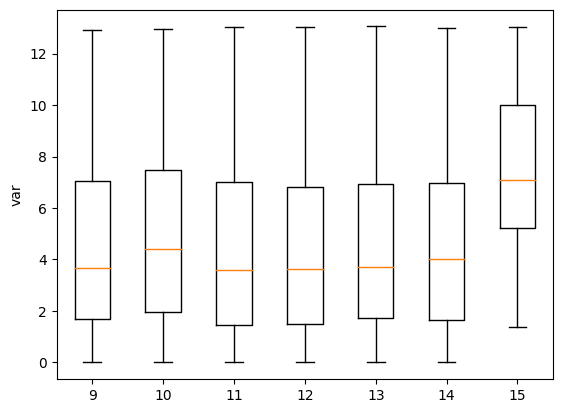

Segundo grupo
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$


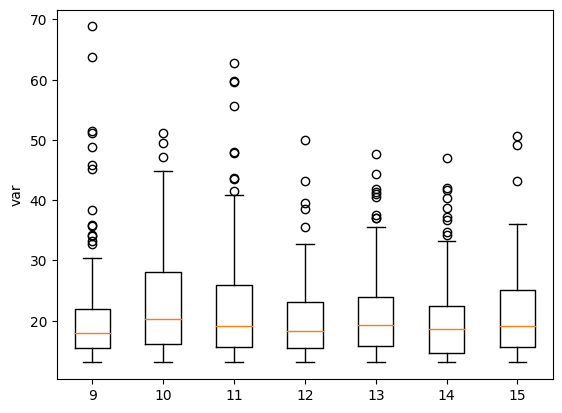

In [350]:
print("Primer grupo")
print("$$$$"*18)
box(2,2,"intervalo",0)
print("Segundo grupo")
print("$$$$"*18)
box(2,2,"intervalo",1)

In [349]:
arribo['Llegada'].max()

Timestamp('1900-01-01 20:33:16')

##Limpiando el intervalo 15 de la prueba.
Y realizando nuevamente la comprobación kruskal y leneve.

In [363]:
base['kmeans']=df[2]
base=base[(base['intervalo']!=15)]
kruskal,levene,pruebavar=pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
arreglo=[]
sorce=[]
turno=[]
for i in base['kmeans'].unique():
  eval=base[(base['kmeans']==i)]
  for j in cosas:
    if len(eval[j].unique())>1:
      sorce.append(j)
      turno.append(t)
      arreglo.append(i)
      kruskal=pd.concat([kruskal,pg.kruskal(eval, dv='min_cliente', between=j)])
      levene=pd.concat([levene,pd.DataFrame(pg.homoscedasticity(eval, dv="min_cliente", group=j))])
      pruebavar=pd.concat([pruebavar,pg.homoscedasticity(eval, dv="min_cliente", group=j, method="bartlett", alpha=.05)])

kruskal['grupo']=arreglo
levene['grupo']=arreglo
pruebavar['grupo']=arreglo
kruskal['turno']=turno
levene['turno']=turno
pruebavar['turno']=turno
result=[]
for i in kruskal['p-unc']:
  if i<=5e-02:
    result.append(False)
  else:
    result.append(True)
kruskal["Independencia"]=result
levene['Source']=sorce

In [376]:
levene

,W,pval,equal_var,grupo,turno,Source
levene,1.298190,0.273619,True,1,2,Mes
levene,1.006395,0.419790,True,1,2,dia
levene,0.956379,0.430771,True,1,2,TipoServ.
levene,1.772224,0.116135,True,1,2,intervalo
levene,1.587003,0.208134,True,1,2,Cuadrilla
levene,2.010583,0.134068,True,0,2,Mes
levene,1.206217,0.299757,True,0,2,dia
levene,0.411338,0.800603,True,0,2,TipoServ.
levene,0.658698,0.654860,True,0,2,intervalo
levene,2.651511,0.103543,True,0,2,Cuadrilla


In [371]:
kruskal

,Source,ddof1,H,p-unc,grupo,turno,Independencia
Kruskal,Mes,2,3.448259,0.178328,1,2,True
Kruskal,dia,6,4.762376,0.574631,1,2,True
Kruskal,TipoServ.,4,1.763259,0.779197,1,2,True
Kruskal,intervalo,5,9.461083,0.092027,1,2,True
Kruskal,Cuadrilla,1,0.608688,0.435282,1,2,True
Kruskal,Mes,2,0.314334,0.854561,0,2,True
Kruskal,dia,6,5.949979,0.428817,0,2,True
Kruskal,TipoServ.,4,3.337821,0.502962,0,2,True
Kruskal,intervalo,5,7.219432,0.204826,0,2,True
Kruskal,Cuadrilla,1,0.536161,0.464028,0,2,True


#Graficas

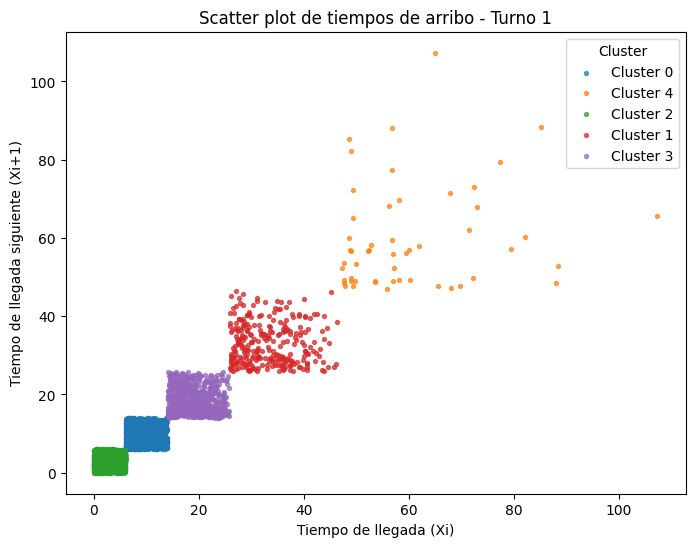

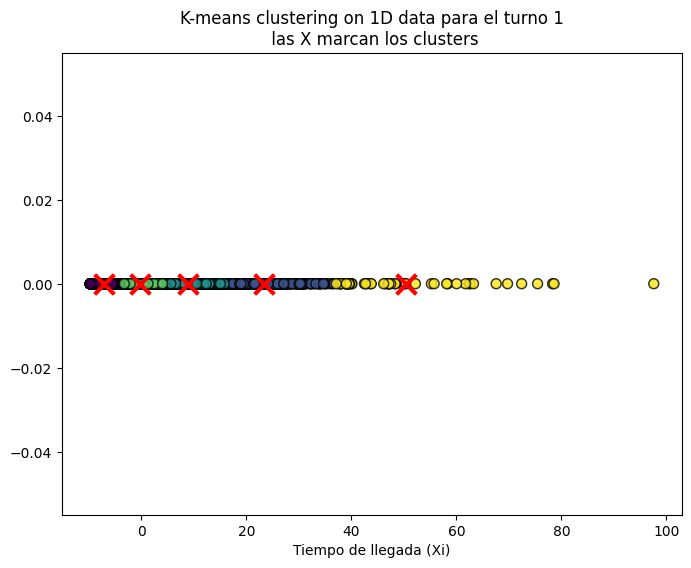

In [332]:
dispercion(1,5)
grafica1d(1,5)

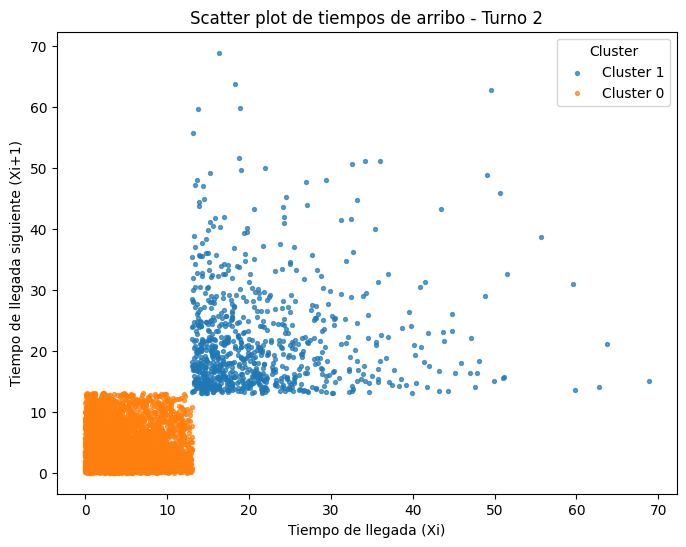

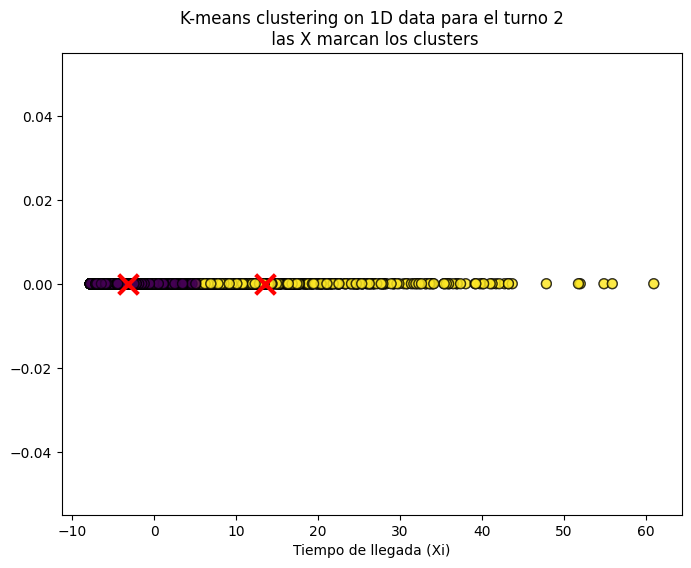

In [333]:
dispercion(2,2)
grafica1d(2,2)

#Corrigiendo el clustering de intervalo para el grupo 0 para que de kruskal True, en el turno 2


In [338]:
kruskal,levene,pruebavar=pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
arreglo=[]
sorce=[]

base=arribo[(arribo['Turno']==2)]
base=base.reset_index()
X = np.array(base['min_cliente']).reshape(-1, 1)
df=pd.DataFrame()
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)
base['kmeans'] = kmeans.labels_

base=base[(base['kmeans']==0)]
base=base.reset_index()

X = np.array(base['min_cliente']).reshape(-1, 1)
df=pd.DataFrame()

for k in [2,3,4,5,6,7,8,9,10,11,12]:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(X)
  df[k] = kmeans.labels_

cosas=["Mes","dia","TipoServ.","intervalo","Cuadrilla"]

for k in list(df.columns):
  base['kmeans']=df[k]

  for i in base['kmeans'].unique():
    eval=base[(base['kmeans']==i)]

    for j in cosas:
      if len(eval[j].unique())>1:
        mete=(k,i)
        sorce.append(j)
        arreglo.append(mete)
        kruskal=pd.concat([kruskal,pg.kruskal(eval, dv='min_cliente', between=j)])
        levene=pd.concat([levene,pd.DataFrame(pg.homoscedasticity(eval, dv="min_cliente", group=j))])
        pruebavar=pd.concat([pruebavar,pg.homoscedasticity(eval, dv="min_cliente", group=j, method="bartlett", alpha=.05)])

kruskal['grupo']=arreglo
levene['grupo']=arreglo
pruebavar['grupo']=arreglo
result=[]
for i in kruskal['p-unc']:
  if i<=5e-02:
    result.append(False)
  else:
    result.append(True)
kruskal["Independencia"]=result
levene['Source']=sorce

In [339]:
for i in [2,3,4,5,6,7,8,9,10,11,12]:
  print("%%%"*10)
  print("Para grupos de "+str(i))
  print("--"*10)
  print(kruskal[(kruskal['grupo'].apply(lambda x: x[0] == i))&(kruskal['Independencia']==False)])
  print("++"*10)
  print(levene[(levene['grupo'].apply(lambda x: x[0] == i))&(levene['equal_var']==False)])
  print("--"*10)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para grupos de 2
--------------------
            Source  ddof1          H     p-unc   grupo  Independencia
Kruskal  intervalo      6  16.365988  0.011919  (2, 1)          False
Kruskal        dia      6  12.748099  0.047215  (2, 0)          False
++++++++++++++++++++
Empty DataFrame
Columns: [W, pval, equal_var, grupo, Source]
Index: []
--------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para grupos de 3
--------------------
Empty DataFrame
Columns: [Source, ddof1, H, p-unc, grupo, Independencia]
Index: []
++++++++++++++++++++
               W      pval  equal_var   grupo     Source
levene  2.592536  0.016871      False  (3, 1)        dia
levene  6.518627  0.010808      False  (3, 1)  Cuadrilla
--------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para grupos de 4
--------------------
            Source  ddof1         H     p-unc   grupo  Independencia
Kruskal  Cuadrilla      1  5.616899  0.017788  (4, 0)          False
++++++++++++++++++++
Empty DataFrame

###Para el grupo 4, el conjunto 0 en cuadrilla


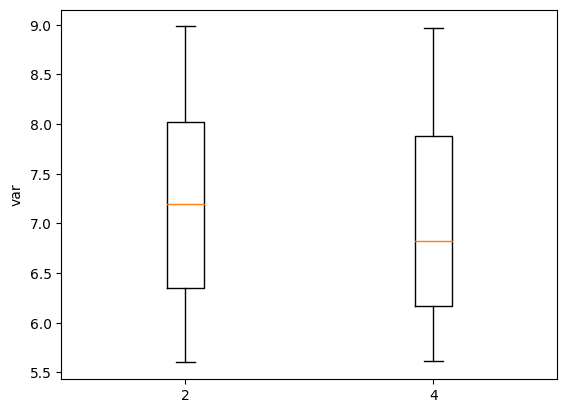

In [344]:
box(2,4,"Cuadrilla",0)

###Para el grupo cinco, el conjunto día 3

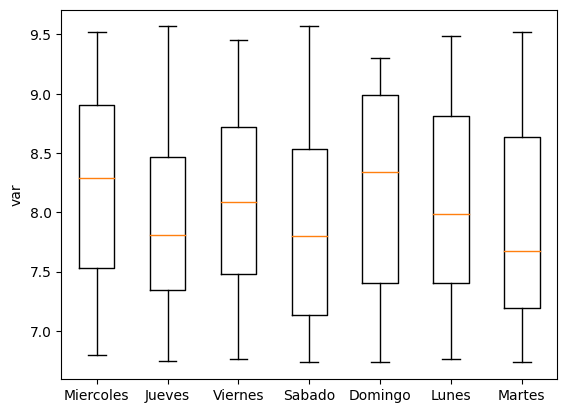

In [345]:
box(2,5,"dia",3)

##Sacando las fit


###Para el turno 1, 5 diferentes

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0269173] [loc=9.444 scale=2.242]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.0248178] [loc=6.050 scale=3.394]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.0248178] [loc=-268435449.950 scale=268435456.000]
[distfit] >INFO> [dweibull  ] [0.02 sec] [RSS: 0.0361251] [loc=9.655 scale=2.134]
[distfit] >INFO> [t         ] [0.34 sec] [RSS: 0.0269183] [loc=9.444 scale=2.242]
[distfit] >INFO> [genextreme] [0.06 sec] [RSS: 0.0227742] [loc=8.519 scale=2.007]
[distfit] >INFO> [gamma     ] [0.06 sec] [RSS: 0.015343] [loc=5.811 scale=1.846]
[distfit] >INFO> [lognorm   ] [0.00 sec] [RSS: 0.0209869] [loc=2.497 scale=6.584]
[distfit] >INFO> [beta      ] [0.11 sec] [RSS: 0.00137391] [loc=6.050 scale=7.998]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0128562] [loc=6.050 scale=7.967]
[distfit] >INFO> [loggamma  ] [0.06 sec] [RSS: 0.0264912] [loc=-664.731 scale=91.234]
[distfit] >INFO> fit
[distfit

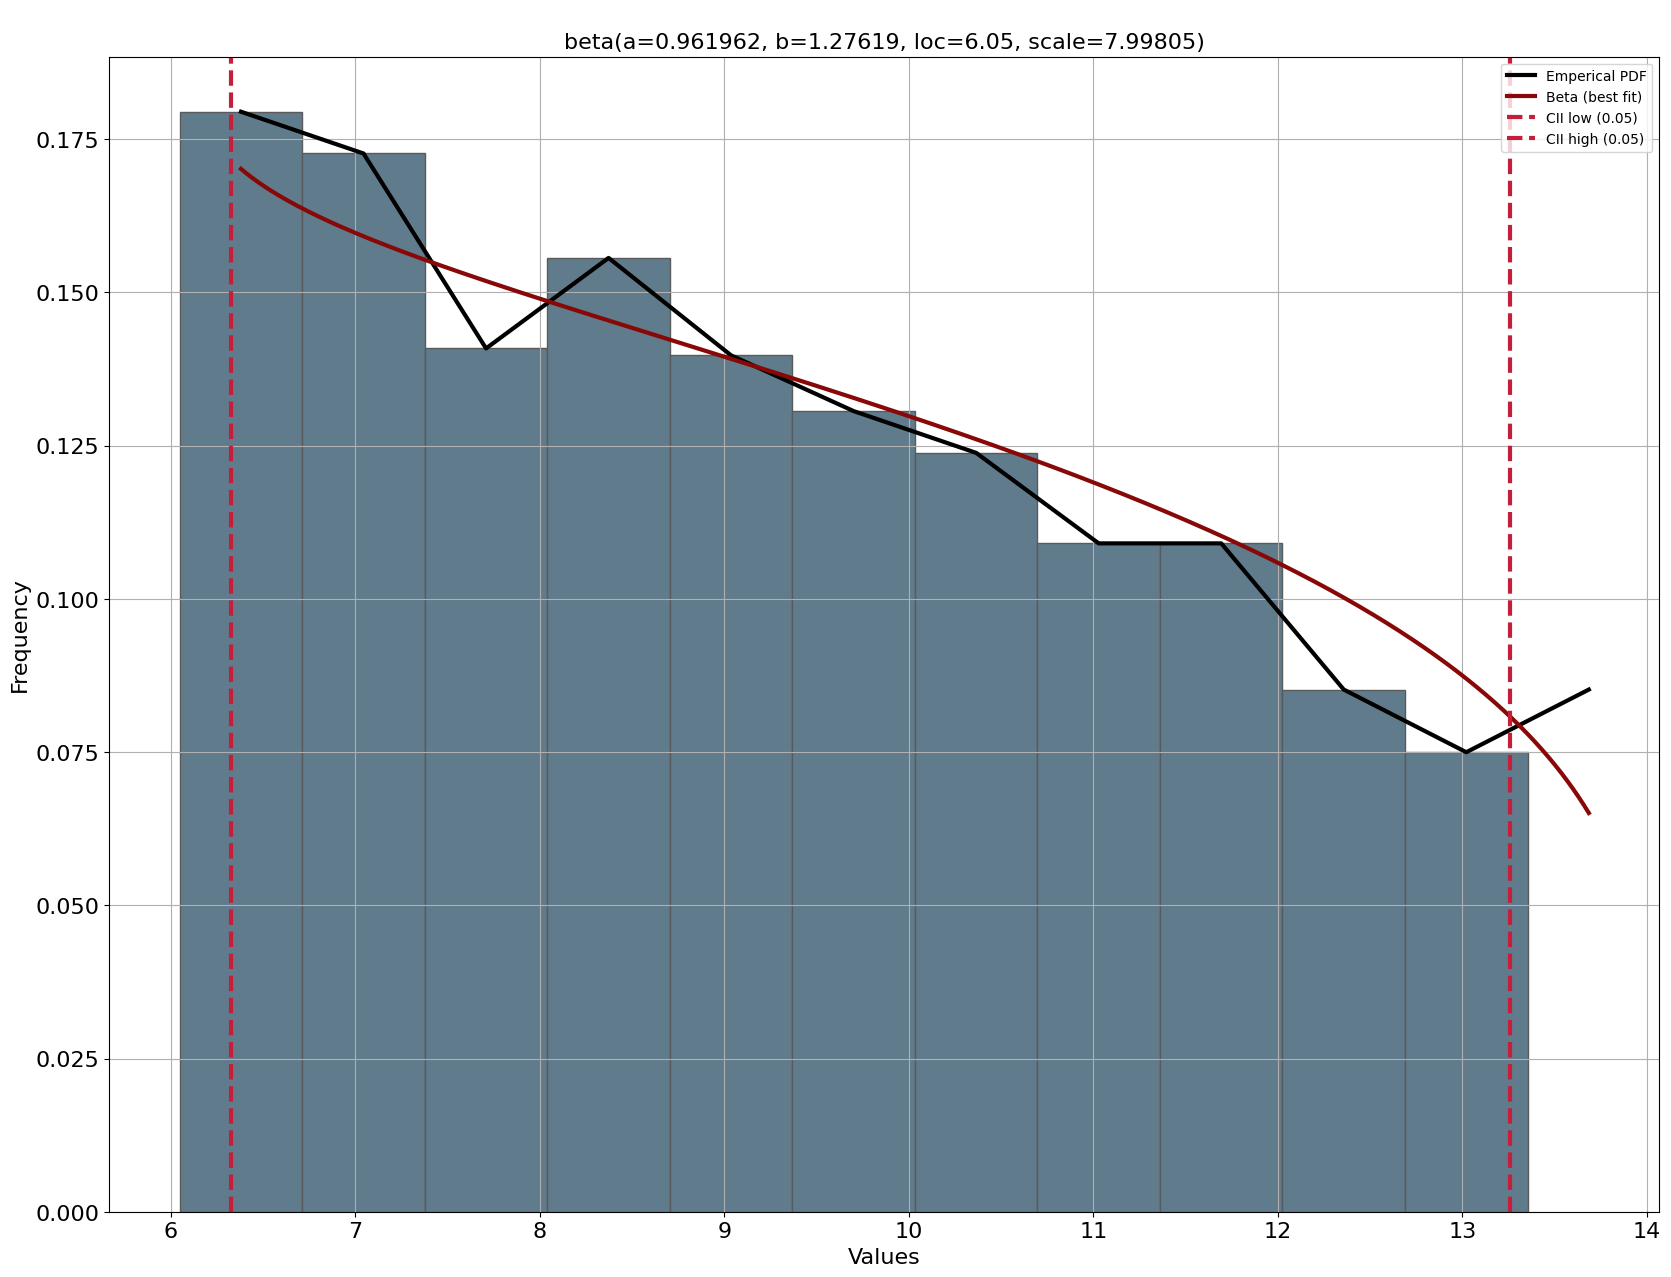

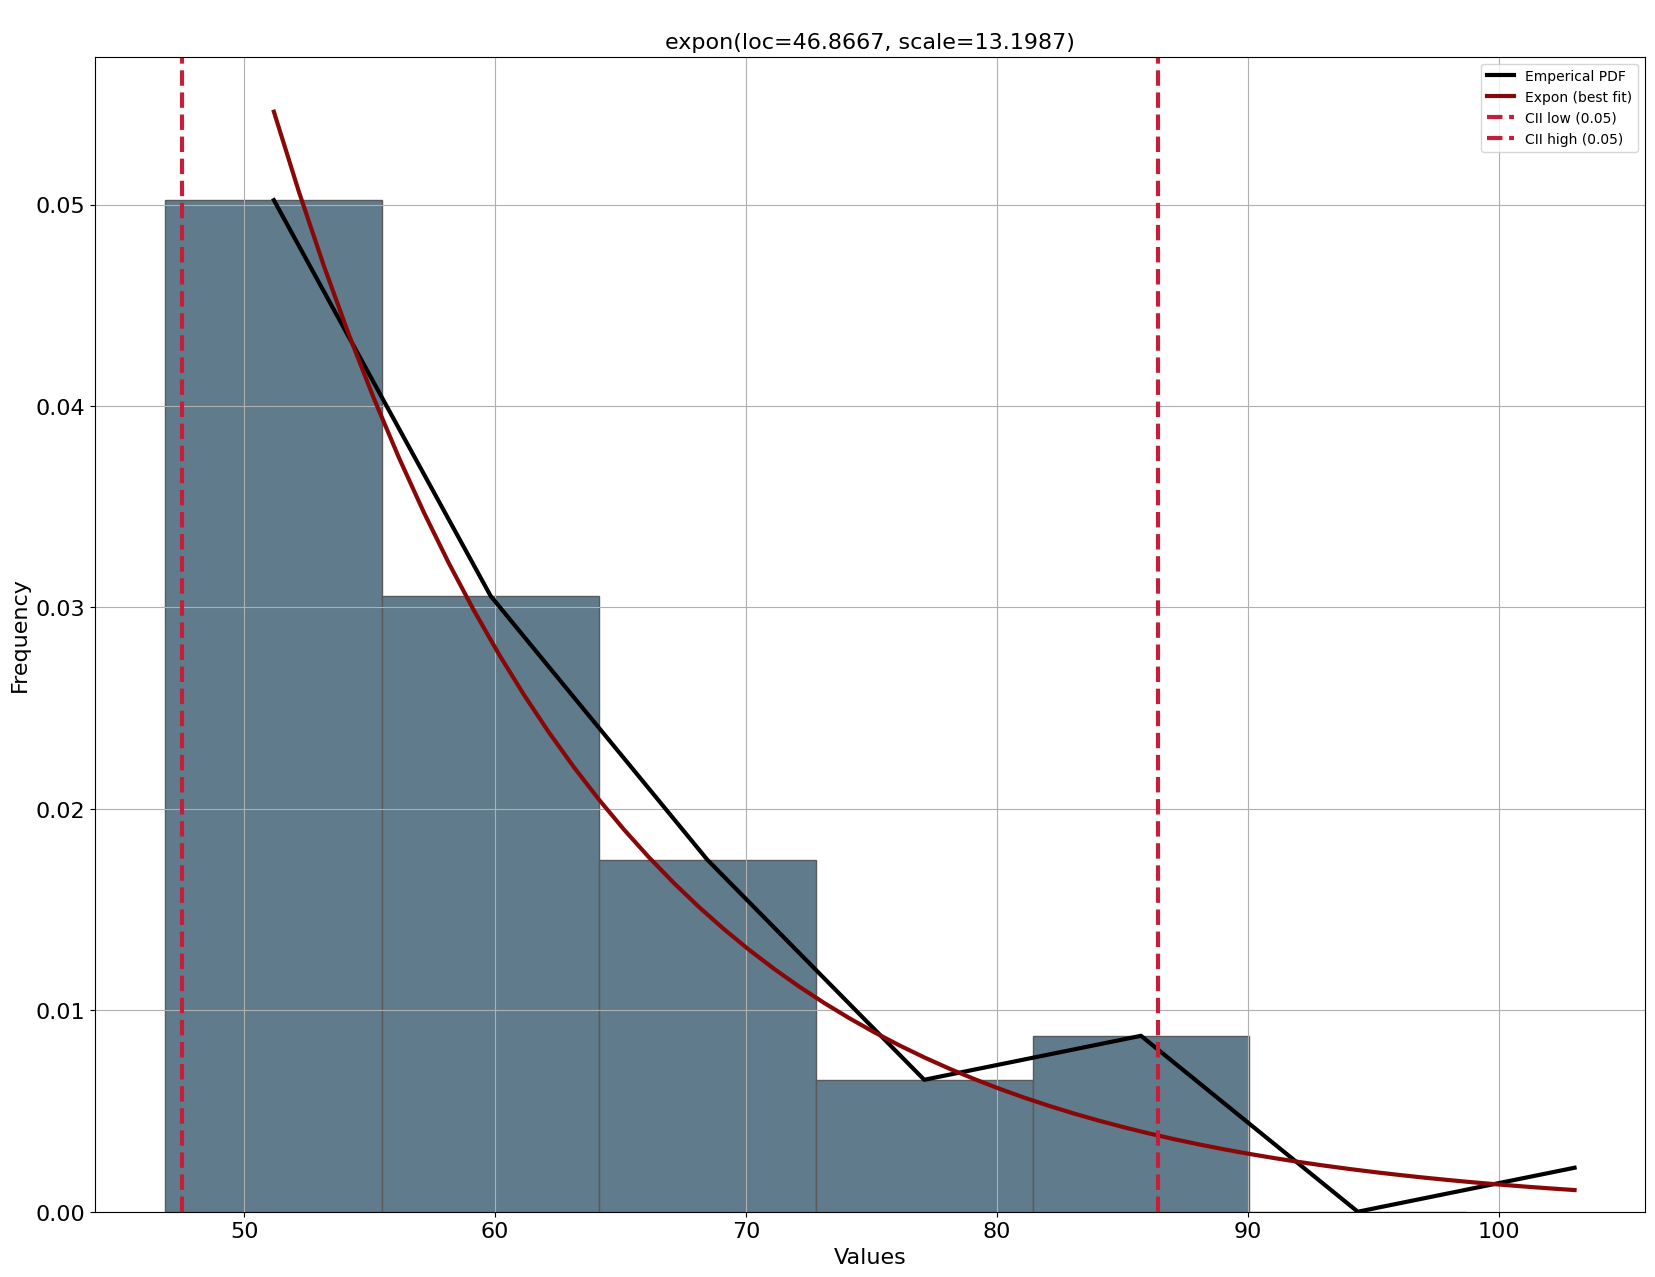

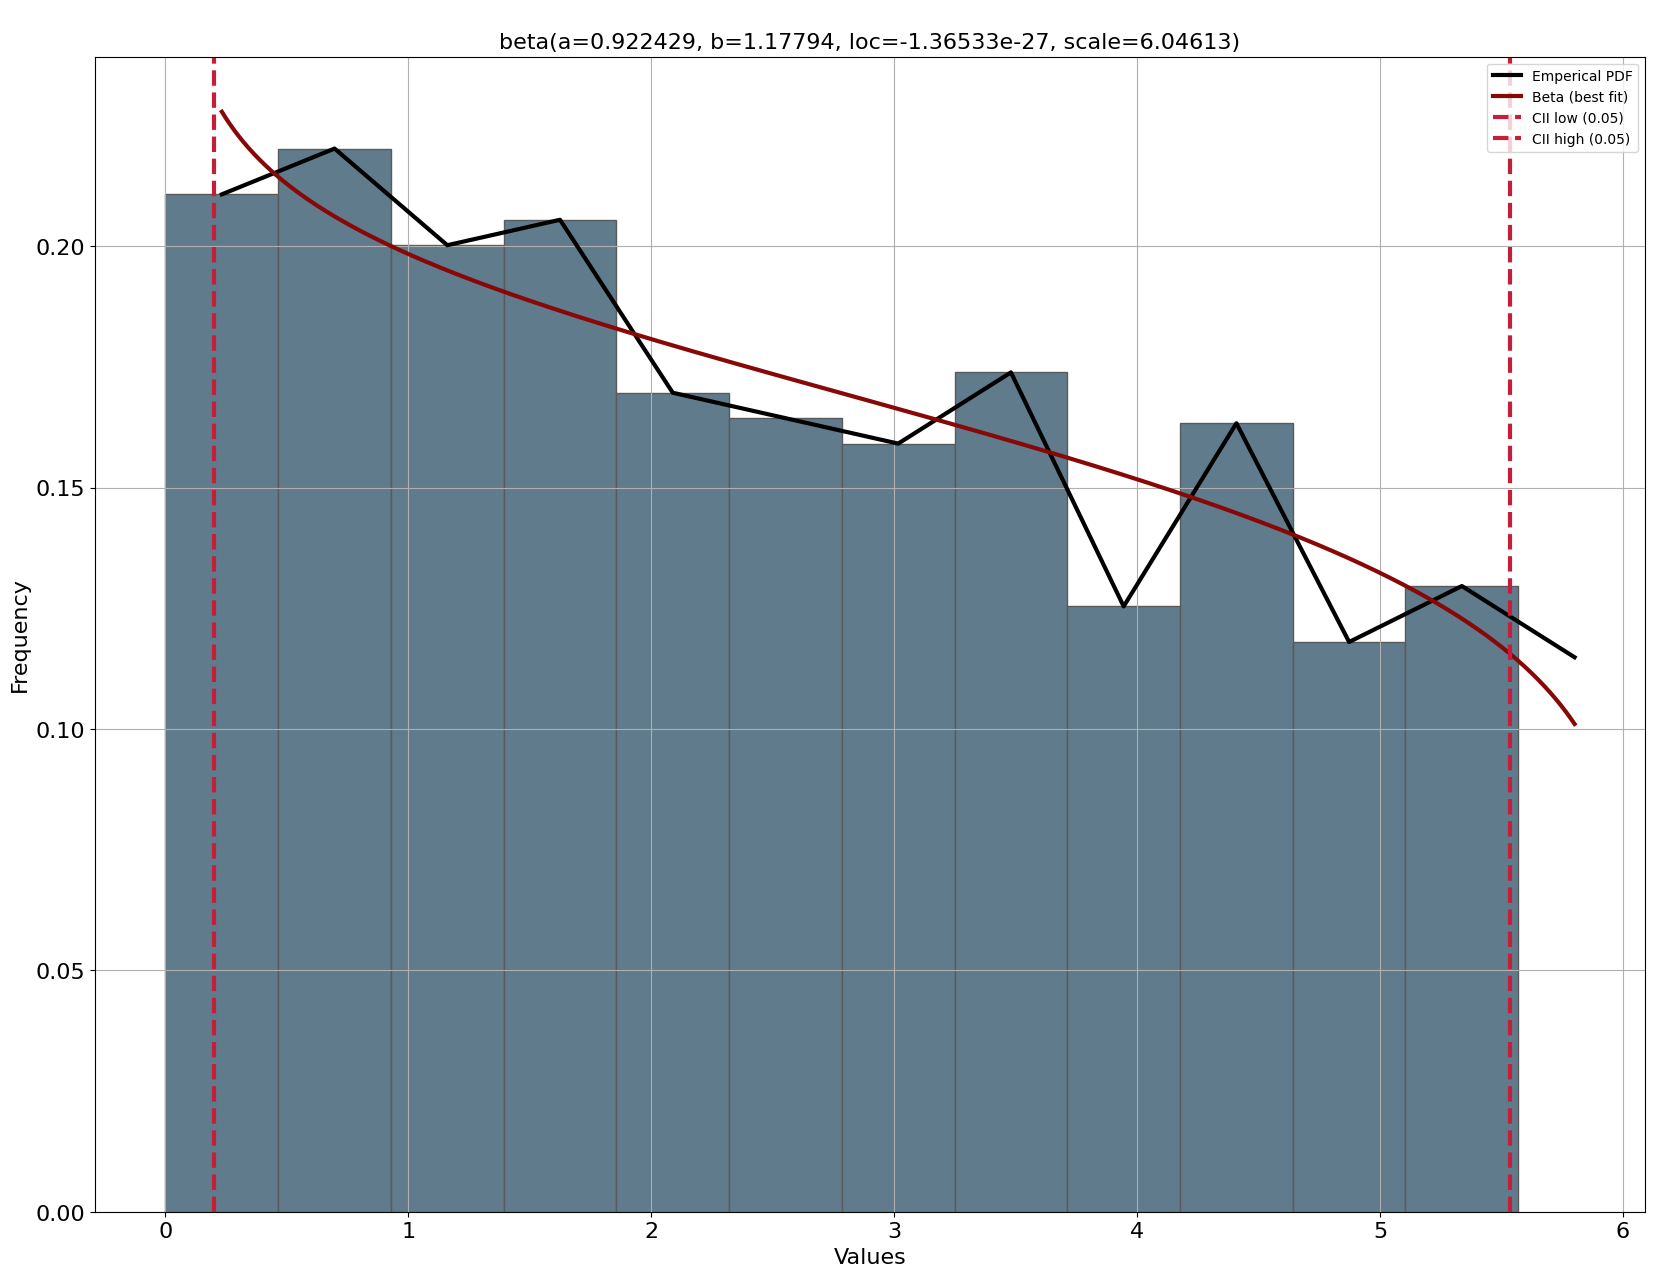

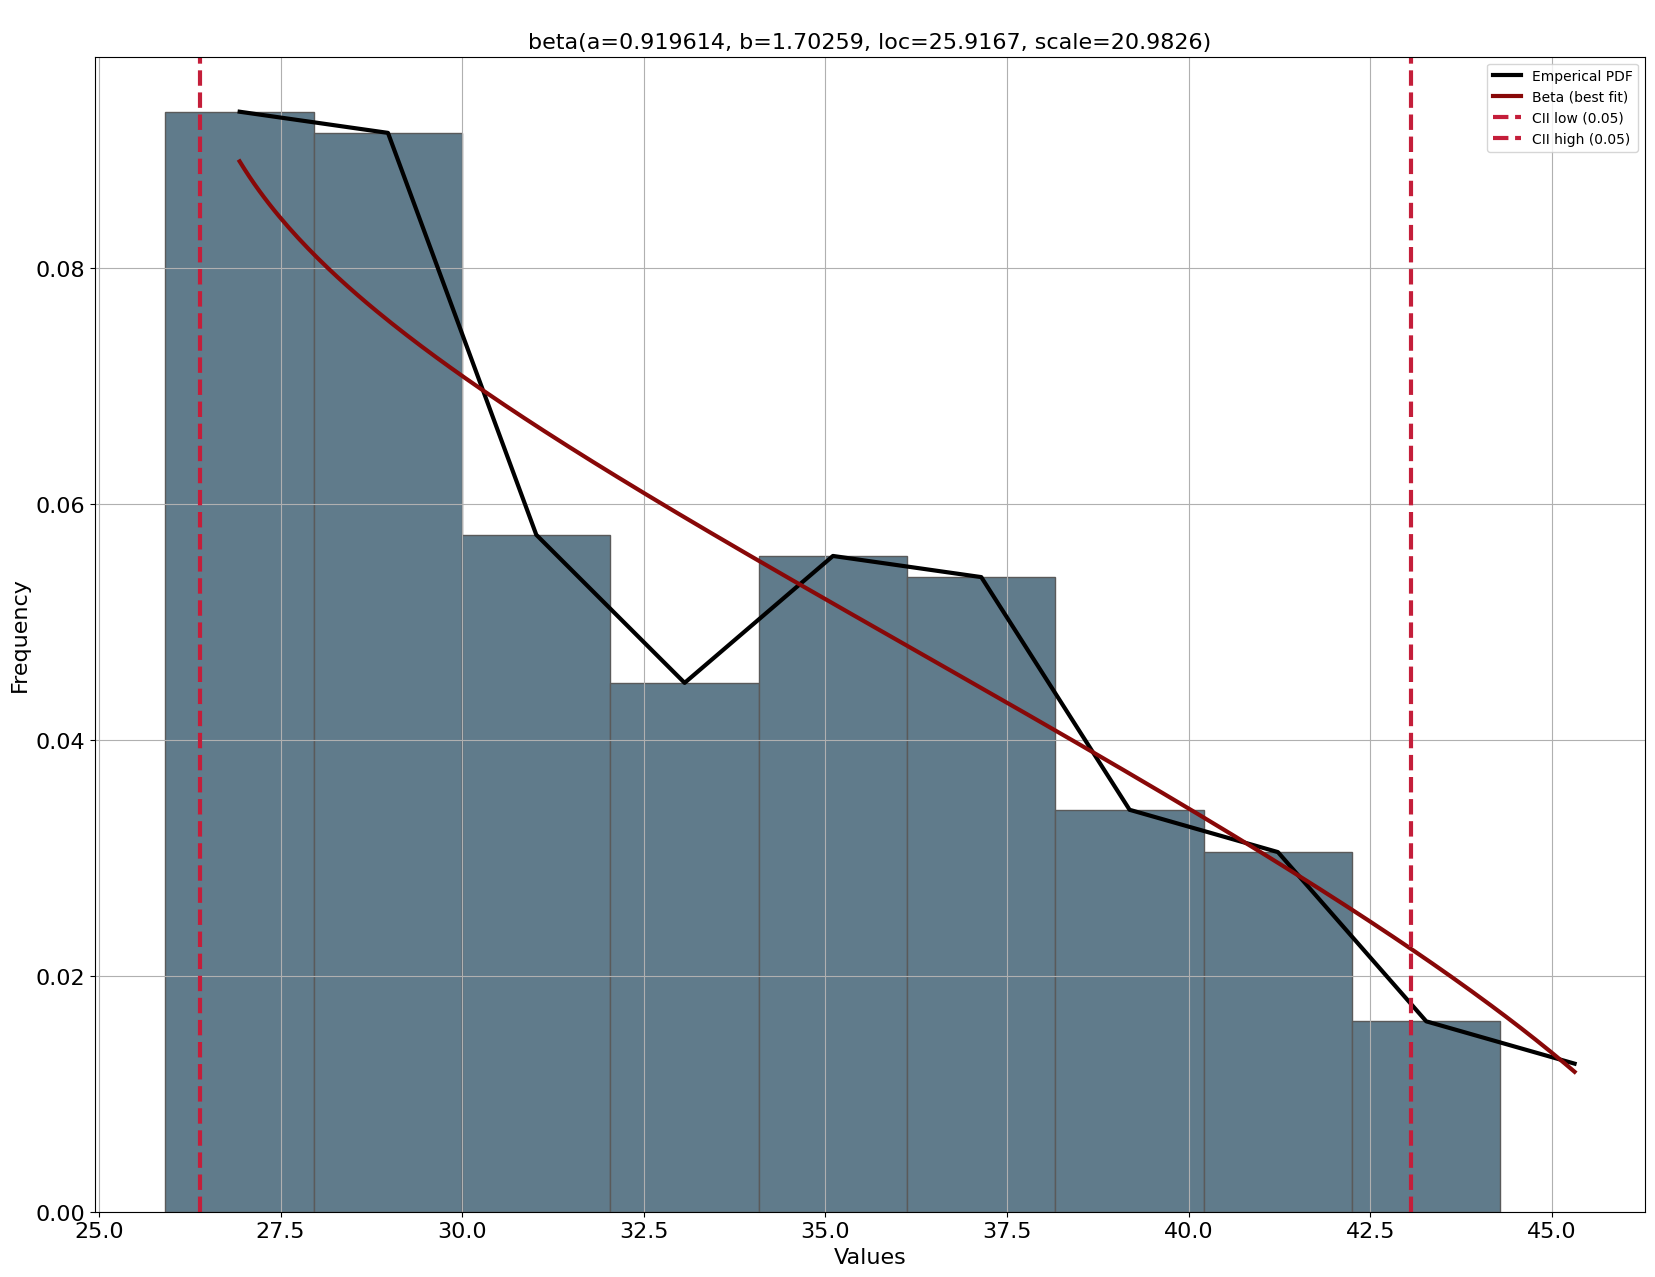

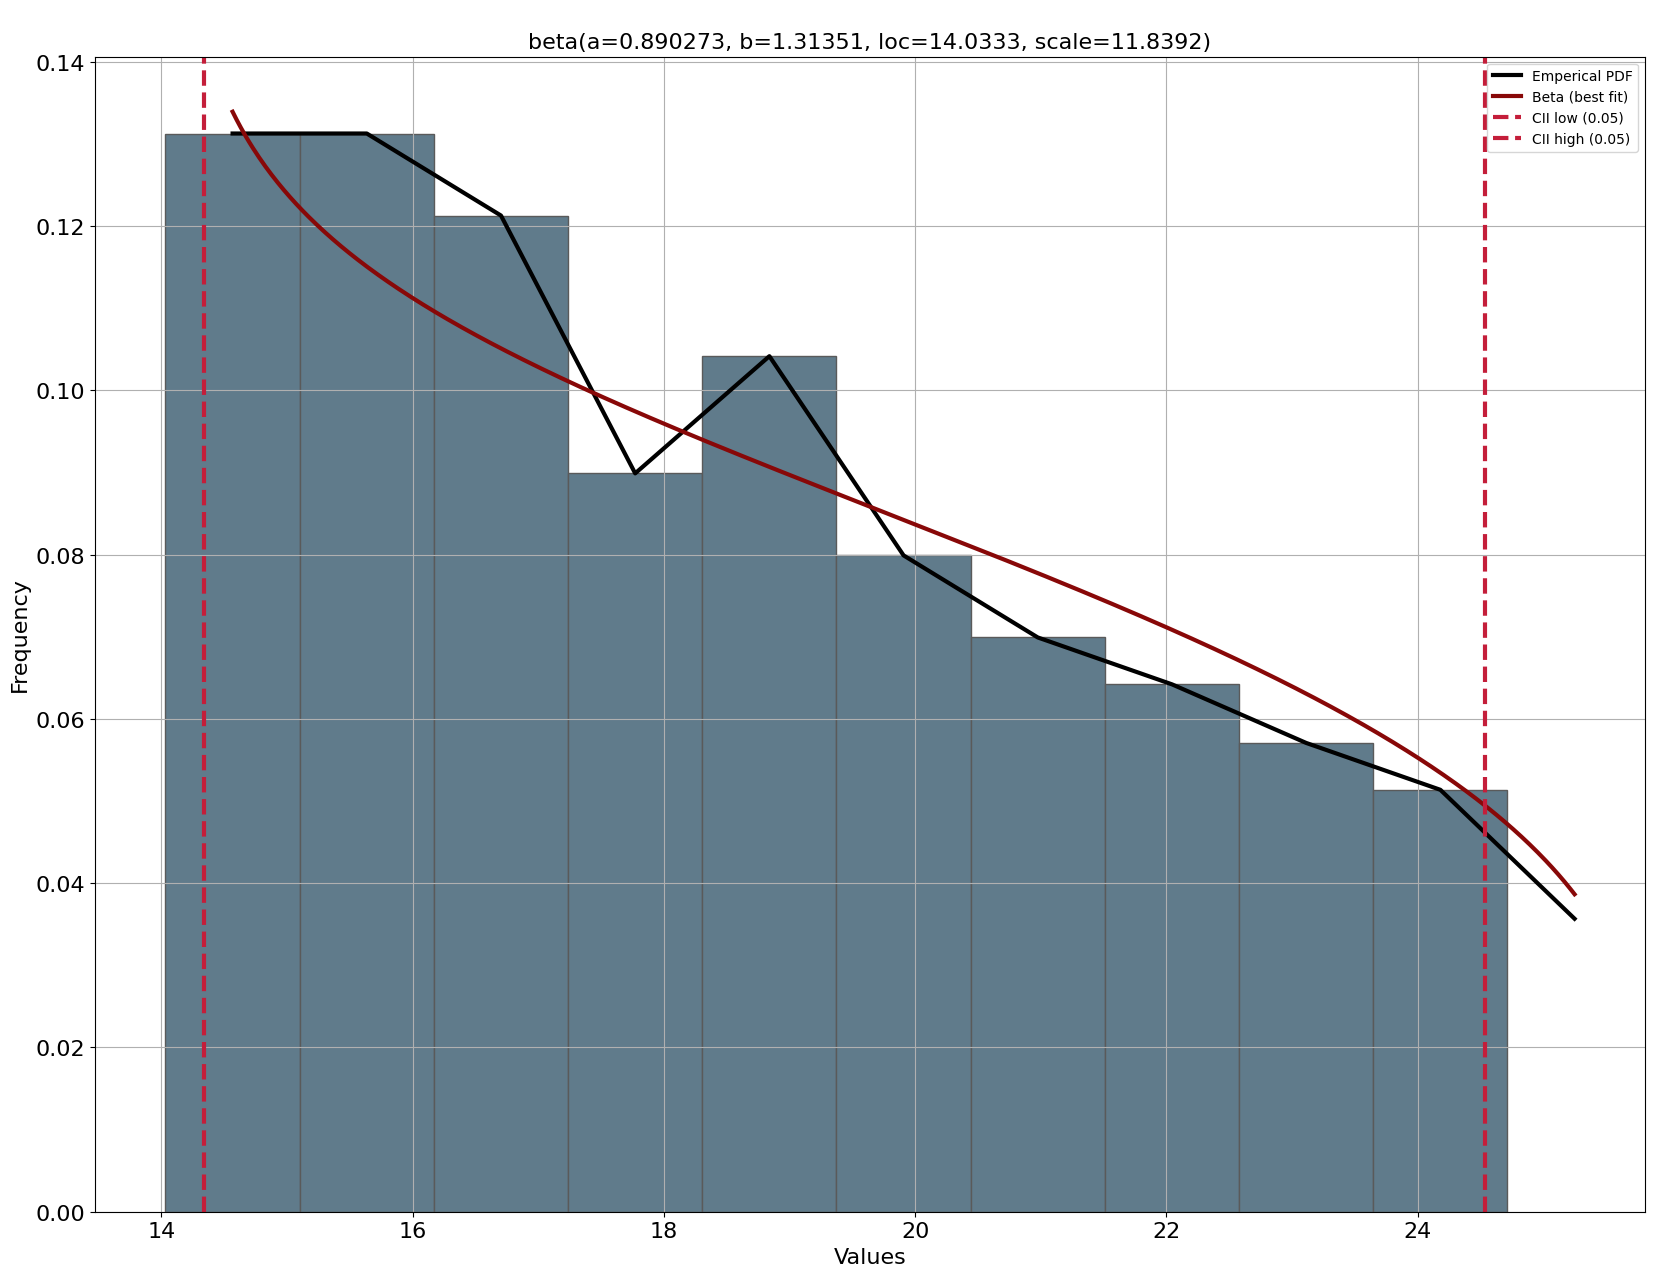

In [353]:
fit(1,5,1000)

In [321]:
cosas=["Mes","dia","TipoServ.","Servidor","Cuadrilla"]
for i in cosas:
  print("%%%%"*10)
  print("Para "+i)
  print("$$$"*10)
  print("Los valores normales regulares, es decir, el conteo")
  print("---"*10)
  print(pd.crosstab(base['kmeans'],base[i]))
  print("$$$"*10)
  print("Los valores de representación ocurrencia, es decir, el porcentaje")
  print("---"*10)
  print(pd.crosstab(base['kmeans'],base[i],normalize='index'))

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para Mes
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Los valores normales regulares, es decir, el conteo
------------------------------
Mes     Abril  Noviembre  Septiembre
kmeans                              
0         439        429         458
1          93        105          75
2         675        643         727
3         209        203         244
4          22         17          14
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Los valores de representación ocurrencia, es decir, el porcentaje
------------------------------
Mes        Abril  Noviembre  Septiembre
kmeans                                 
0       0.331071   0.323529    0.345400
1       0.340659   0.384615    0.274725
2       0.330073   0.314425    0.355501
3       0.318598   0.309451    0.371951
4       0.415094   0.320755    0.264151
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para dia
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Los valores normales regulares, es decir, el conteo
------------------------------
dia  

###Para turno 2, tres diferentes, dos de grupo grande, una grupo chico.

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.00994228] [loc=21.455 scale=8.468]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.000199774] [loc=13.067 scale=8.388]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.000195046] [loc=-783.273 scale=796.340]
[distfit] >INFO> [dweibull  ] [0.02 sec] [RSS: 0.00746975] [loc=19.380 scale=6.063]
[distfit] >INFO> [t         ] [0.26 sec] [RSS: 0.00662457] [loc=18.979 scale=4.866]
[distfit] >INFO> [genextreme] [0.08 sec] [RSS: 0.00146568] [loc=16.811 scale=3.801]
[distfit] >INFO> [gamma     ] [0.06 sec] [RSS: 0.000196394] [loc=13.067 scale=8.626]
[distfit] >INFO> [lognorm   ] [0.00 sec] [RSS: 0.00060202] [loc=12.525 scale=5.791]
[distfit] >INFO> [beta      ] [0.10 sec] [RSS: 0.000205258] [loc=13.067 scale=507.787]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.02206] [loc=13.067 scale=55.767]
[distfit] >INFO> [loggamma  ] [0.06 sec] [RSS: 0.0101476] [loc=-4067.614 scale=505.111]
[distfit] >INFO>

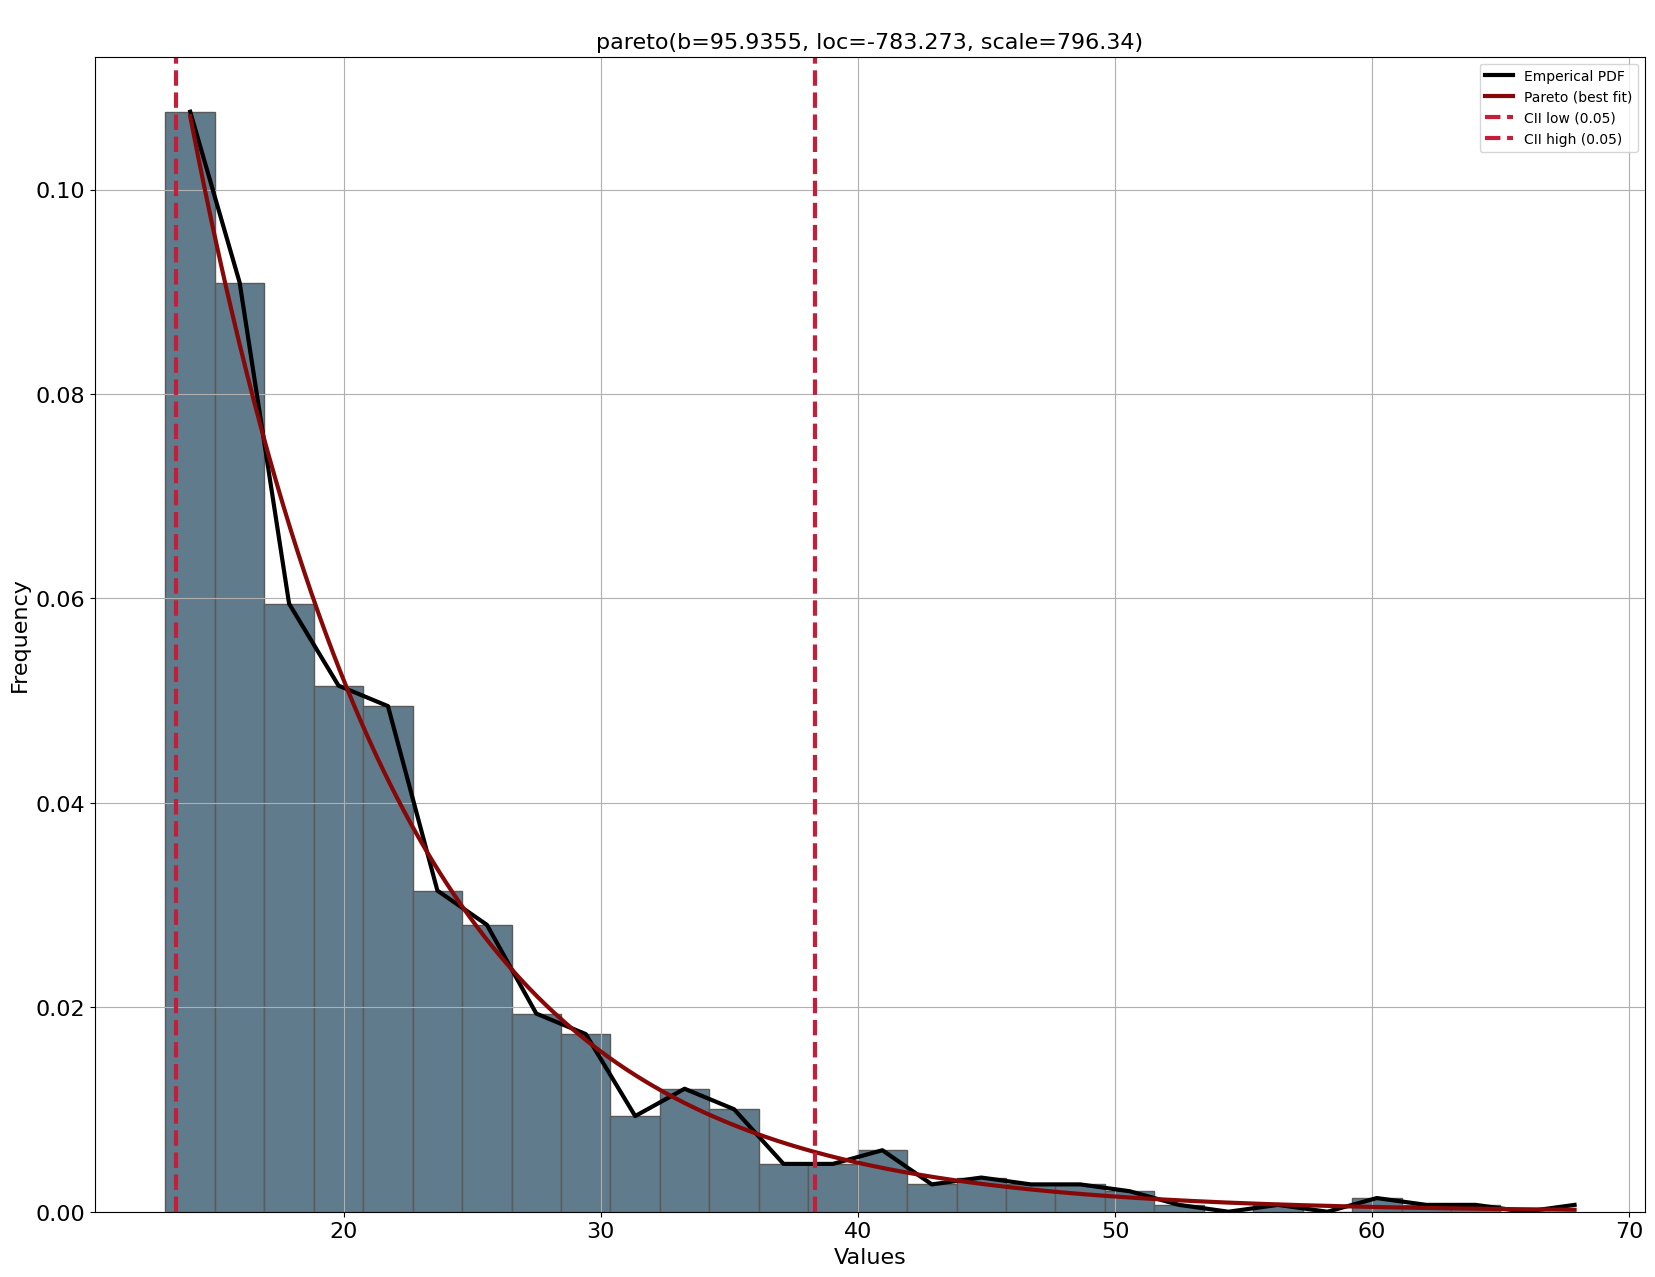

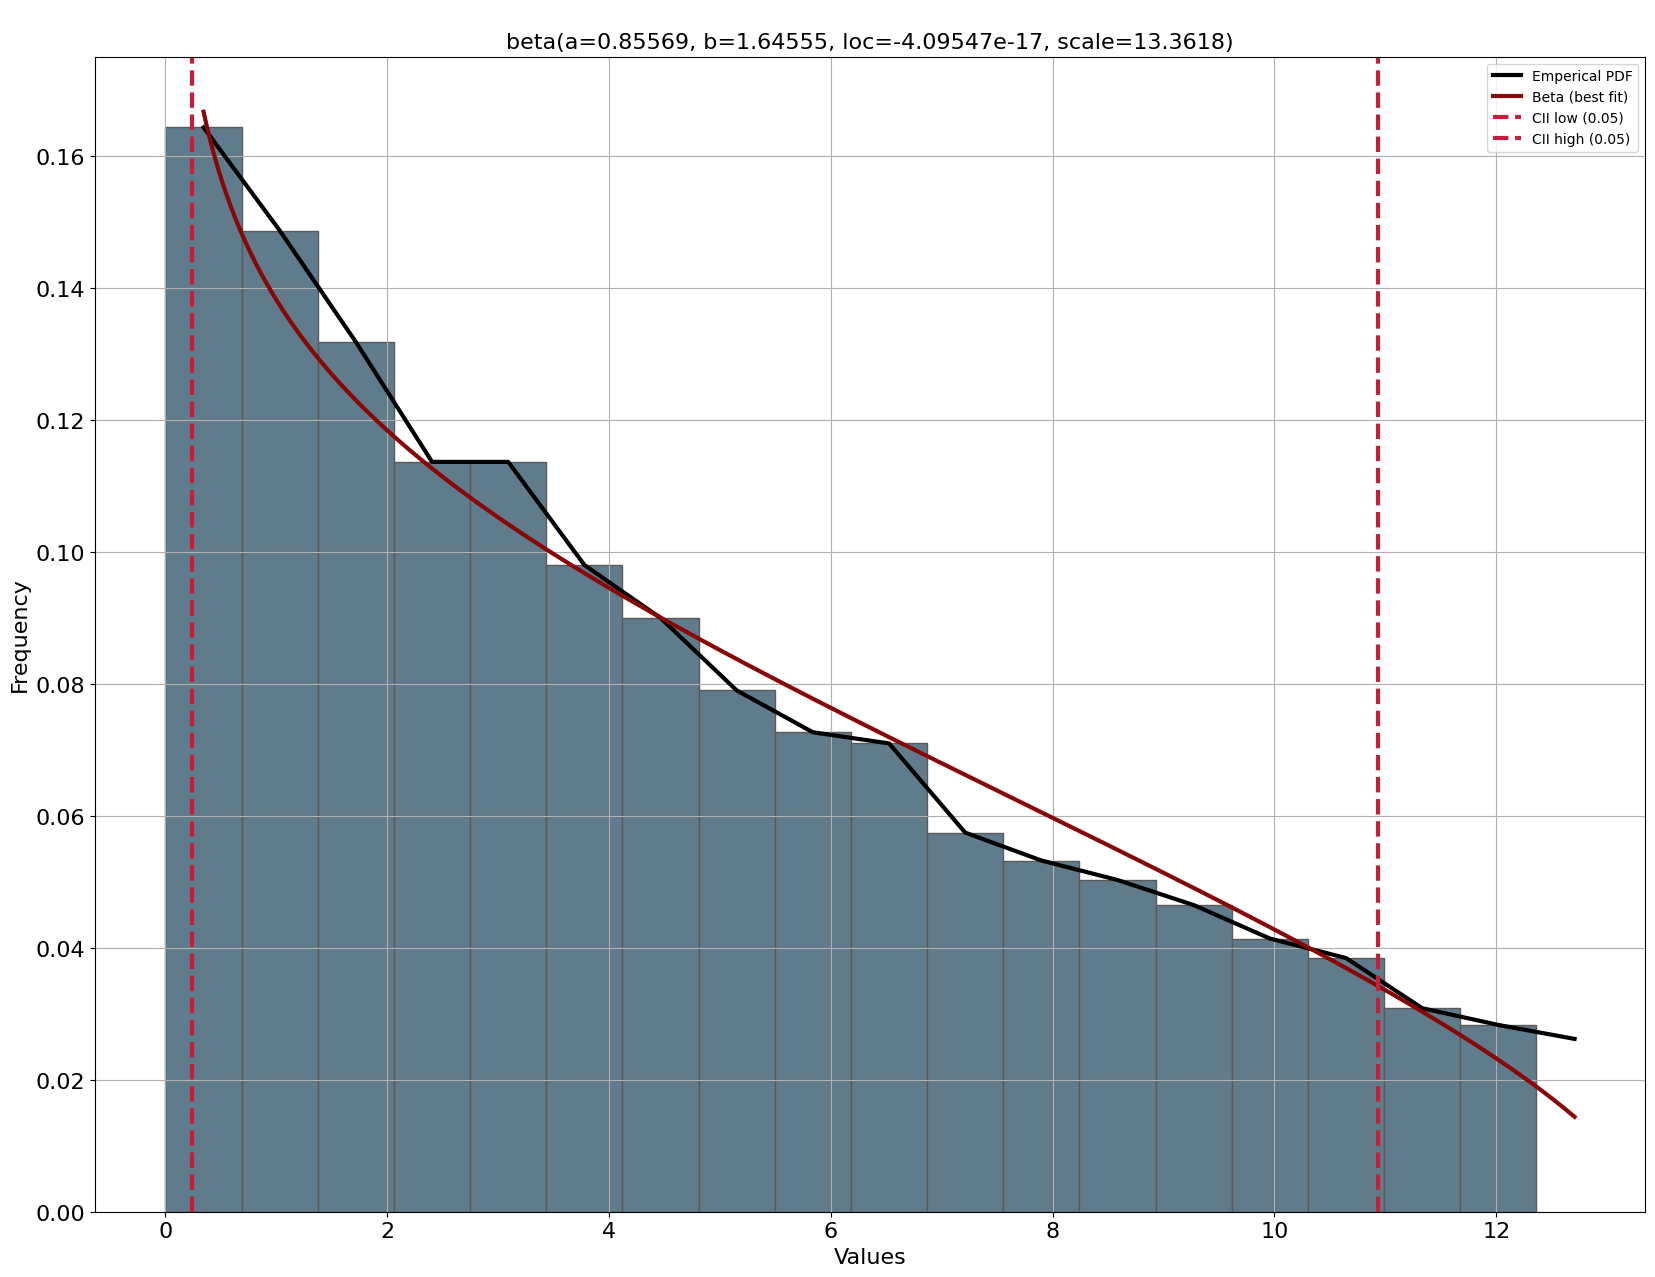

In [379]:
fit(2,2,15)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.000861077] [loc=14.839 scale=9.778]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00116346] [loc=1.367 scale=13.472]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.00116346] [loc=-536870910.633 scale=536870912.000]
[distfit] >INFO> [dweibull  ] [0.01 sec] [RSS: 0.000608104] [loc=13.583 scale=7.463]
[distfit] >INFO> [t         ] [0.21 sec] [RSS: 0.000636654] [loc=13.323 scale=7.072]
[distfit] >INFO> [genextreme] [0.07 sec] [RSS: 0.000538983] [loc=10.161 scale=6.663]
[distfit] >INFO> [gamma     ] [0.01 sec] [RSS: 0.000377705] [loc=0.525 scale=6.778]
[distfit] >INFO> [lognorm   ] [0.00 sec] [RSS: 0.000479197] [loc=-3.605 scale=16.204]
[distfit] >INFO> [beta      ] [0.05 sec] [RSS: 0.000369229] [loc=0.662 scale=367.881]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0032982] [loc=1.367 scale=49.250]
[distfit] >INFO> [loggamma  ] [0.05 sec] [RSS: 0.00087769] [loc=-2980.413 scale=404.165]


(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nbeta(a=1.97592, b=49.2988, loc=0.662212, scale=367.881)'}, xlabel='Values', ylabel='Frequency'>)

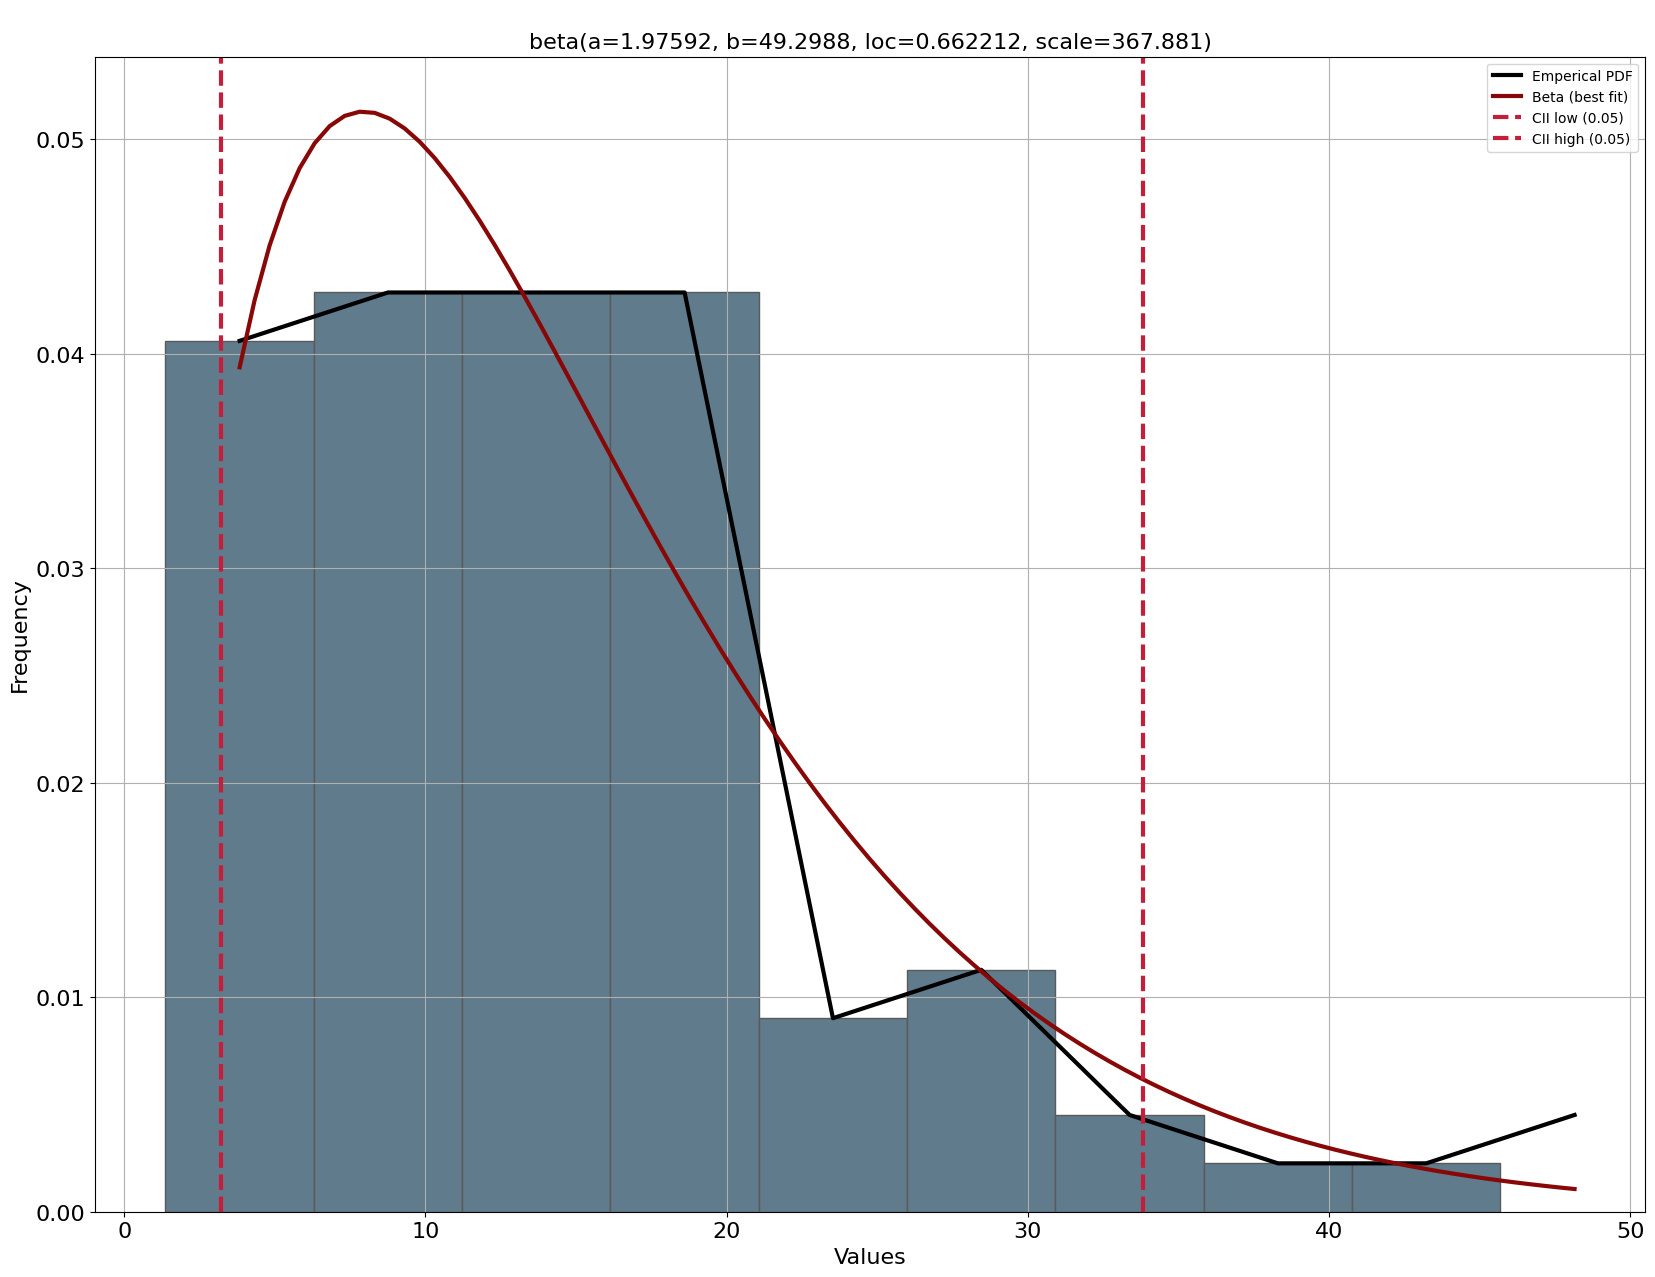

In [381]:
dfit = distfit()
results2 = dfit.fit_transform(arribo[(arribo['intervalo']==15)]['min_cliente'])
results2['summary'].to_excel("grupo_intervalo_15.xlsx")
dfit.plot()

#Realizando Gauss para determinar kmeans, nada concluyente


In [175]:
cosas=["dia","TipoServ.","intervalo","Mes","Cuadrilla"]
kruskal,levene,pruebavar=pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
arreglo=[]
sorce=[]
turno=[]

for t in [1,2]:
  base=arribo[(arribo['Turno']==t)]
  base=base.reset_index()
  X = base[['min_cliente','num_mes','intervalo','tipo_serv','num_dia','dia_mes','Cuadrilla']]

  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  df=pd.DataFrame()
  for n_components in [2,3,4,5,6,7,8,9,10,11,12,13,14]:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_scaled)

    # Obtener las etiquetas predichas
    labels = gmm.predict(X_scaled)

    # Agregar las etiquetas al DataFrame original
    df[n_components] = labels


  for k in list(df.columns):
    base['kmeans']=df[k]

    for i in base['kmeans'].unique():
      eval=base[(base['kmeans']==i)]

      for j in cosas:
        if len(eval[j].unique())>1:
          mete=(k,i)
          sorce.append(j)
          turno.append(t)
          arreglo.append(mete)
          kruskal=pd.concat([kruskal,pg.kruskal(eval, dv='min_cliente', between=j)])
          levene=pd.concat([levene,pd.DataFrame(pg.homoscedasticity(eval, dv="min_cliente", group=j))])
          pruebavar=pd.concat([pruebavar,pg.homoscedasticity(eval, dv="min_cliente", group=j, method="bartlett", alpha=.05)])

kruskal['grupo']=arreglo
levene['grupo']=arreglo
pruebavar['grupo']=arreglo
kruskal['turno']=turno
levene['turno']=turno
pruebavar['turno']=turno
kruskal["Independencia"] = kruskal['p-unc'] <= 0.05
levene['Source']=sorce

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:2902: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 + 1.0/(3*(k - 1)) * ((np.sum(1.0/(Ni - 1.0), axis=0)) -
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:2902: RuntimeWarning: div

In [176]:
for t in [1,2]:
  print("$$$$"*10)
  print("Para el turno "+str(t))
  for i in [2,3,4,5,6,7,8,9,10,11,12,13,14]:
    print("%%%"*10)
    print("Para grupos de "+str(i))
    print("--"*10)
    print(kruskal[(kruskal['grupo'].apply(lambda x: x[0] == i))&(kruskal['Independencia']==False)&(kruskal['turno']==t)])
    print("++"*10)
    print(levene[(levene['grupo'].apply(lambda x: x[0] == i))&(levene['equal_var']==False)&(levene['turno']==t)])
    print("--"*10)

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Para el turno 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para grupos de 2
--------------------
            Source  ddof1         H     p-unc   grupo  turno  Independencia
Kruskal        dia      4  2.831563  0.586397  (2, 0)      1          False
Kruskal  TipoServ.      4  3.487359  0.479803  (2, 0)      1          False
Kruskal        Mes      2  0.120702  0.941434  (2, 0)      1          False
Kruskal  Cuadrilla      1  1.731680  0.188196  (2, 0)      1          False
Kruskal        dia      1  1.085045  0.297572  (2, 1)      1          False
Kruskal  TipoServ.      4  8.239910  0.083175  (2, 1)      1          False
Kruskal        Mes      2  5.580851  0.061395  (2, 1)      1          False
++++++++++++++++++++
               W          pval  equal_var   grupo  turno     Source
levene  6.611693  1.338105e-08      False  (2, 0)      1  intervalo
levene  4.424761  7.332107e-05      False  (2, 1)      1  intervalo
--------------------
%%%%%%%%%%%%%%%%%%%%